# 缩放点积注意力

In [9]:
import tensorflow as tf
from attention import DotProductionAttention

dot_att = DotProductionAttention(dropout=0.0)

queries = tf.random.normal(shape=(2, 1, 3))
keys = tf.ones((2, 10, 3))
values = tf.repeat(tf.reshape(tf.range(40, dtype=tf.float32),
                              shape=(1, 10, 4)), repeats=2, axis=0)
valid_lens = tf.constant([2, 6])

res = dot_att(queries, keys, values, valid_lens)
print("attention_weight", dot_att.attention_weights)
print("values", values[0])
print("res", res)

attention_weight tf.Tensor(
[[[0.5        0.5        0.         0.         0.         0.
   0.         0.         0.         0.        ]]

 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
   0.         0.         0.         0.        ]]], shape=(2, 1, 10), dtype=float32)
values tf.Tensor(
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]
 [16. 17. 18. 19.]
 [20. 21. 22. 23.]
 [24. 25. 26. 27.]
 [28. 29. 30. 31.]
 [32. 33. 34. 35.]
 [36. 37. 38. 39.]], shape=(10, 4), dtype=float32)
res tf.Tensor(
[[[ 2.  3.  4.  5.]]

 [[10. 11. 12. 13.]]], shape=(2, 1, 4), dtype=float32)


# 多头注意力

In [7]:
from attention import MultiHeadAttention
import tensorflow as tf

x = tf.reshape(tf.range(12), shape=(1, 2, 6))
x_t = MultiHeadAttention.transpose_qkv(x, 3)
print(x, x_t, MultiHeadAttention.reverse_transpose_qkv(x_t, 3))

tf.Tensor(
[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]]], shape=(1, 2, 6), dtype=int32) tf.Tensor(
[[[ 0  1]
  [ 6  7]]

 [[ 2  3]
  [ 8  9]]

 [[ 4  5]
  [10 11]]], shape=(3, 2, 2), dtype=int32) tf.Tensor(
[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]]], shape=(1, 2, 6), dtype=int32)


In [3]:
from attention import MultiHeadAttention
import tensorflow as tf

batch_size, num_queries = 2, 4
num_hiddens, num_heads = 100, 5
num_kvpairs = 6
valid_lens = tf.constant([3, 2])

attention = MultiHeadAttention(hidden_unit=num_hiddens, num_head=num_heads, dropout=0.5)
queris = tf.ones((batch_size, num_queries, num_hiddens))
keys = tf.ones((batch_size, num_kvpairs, num_hiddens))
values = tf.ones((batch_size, num_kvpairs, 20))

attention(queris, keys, values, valid_lens, training=False).shape

TensorShape([2, 4, 100])

# 位置编码

(1, 60, 32)
(1, 60, 32)
(4, 60)
(60,)


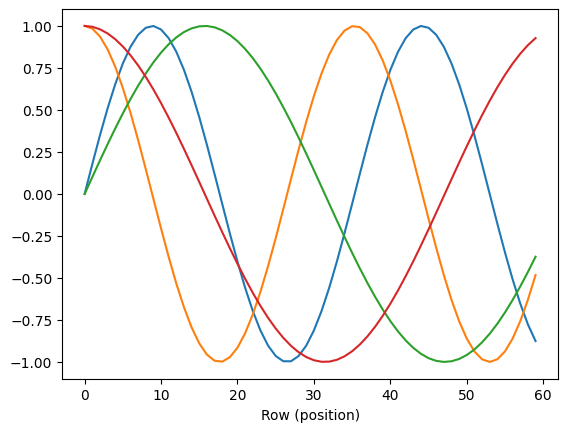

In [10]:
from encoder_decoder_layer import PositionalEncoding
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(hidden_unit=encoding_dim, dropout=0)
x = pos_encoding(tf.zeros((1, num_steps, encoding_dim)), training=False).numpy()
print(x.shape)
p = pos_encoding.pos_values[:, :x.shape[1], :].numpy()
print(p.shape)
print(p[0, :, 6:10].T.shape)
print(np.arange(num_steps).shape)
for i in range(6, 10):
    plt.plot(np.arange(num_steps), p[0, :, i], label=f"Col {i}")
plt.xlabel('Row (position)')
plt.show()

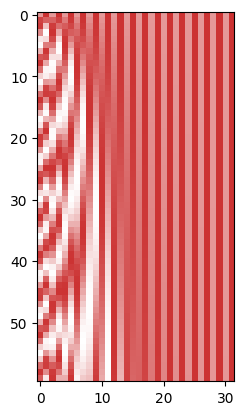

In [16]:
from attention import plot_attention_map
plot_attention_map(np.squeeze(p, axis=0))

# BatchNormalization vs LayerNormalization

In [1]:
import tensorflow as tf
import numpy as np

data = tf.constant(np.arange(4).reshape(2, 2) * 10, dtype=tf.float32)

print(data)
ln = tf.keras.layers.LayerNormalization(axis=-1)
bn = tf.keras.layers.BatchNormalization()

print("layer normal: 每个样本的所有特征进行norm", ln(data))
print("batch normal： 逐个特征的所有样本进行norm", bn(data, training=True))

Metal device set to: Apple M1 Pro
tf.Tensor(
[[ 0. 10.]
 [20. 30.]], shape=(2, 2), dtype=float32)
layer normal: 每个样本的所有特征进行norm tf.Tensor(
[[-0.99998003  0.99998003]
 [-0.99998003  0.99998003]], shape=(2, 2), dtype=float32)
batch normal： 逐个特征的所有样本进行norm tf.Tensor(
[[-0.999995 -0.999995]
 [ 0.999995  0.999995]], shape=(2, 2), dtype=float32)


2023-02-26 11:06:01.526025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-26 11:06:01.526048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 数据加载

In [1]:
from datasets import EnglishChineseTranslateDatasets, EnglishFrenchTranslateDatasets
from data_generator import TranslateDataGenerator
import tensorflow as tf

# ds = EnglishChineseTranslateDatasets()
ds = EnglishFrenchTranslateDatasets()
test_x, test_y = ds.load_test_data()
test_x, test_y = test_x[: 512], test_y[: 512]
gen = TranslateDataGenerator(
    test_x, test_y, x_sentence_len=5, y_sentence_len=5, min_freq=0
)

gen.summary()
enc_x, x_len, dec_x, y_len, target_y = gen[: 1]

building source vocab...
building targe vocab...
converting x to enc_x...
converting y to dec_x...
case count: 512
source: 
  vocab size: 233
  enc_x avg len: 2.994140625
  enc_x max len: 4
targe: 
  vocab size: 497
  dec_x avg len: 4.14453125
  dec_x max len: 6


# 模型建立

In [31]:
from translate_model import TransformerSeq2SeqTranslateModel
import tensorflow as tf
import numpy as np

m = TransformerSeq2SeqTranslateModel(
    enc_vocab_size=len(gen.x_vocab), enc_embedding_size=32,
    dec_vocab_size=len(gen.y_vocab), dec_embedding_size=32,
    dropout=0.1, num_blocks=2, hidden_units=32, ffn_num_hidden=64, num_head=4
)

# 模型训练

In [32]:
m.custom_fit(
    gen,
    batch_size=64,
    epochs=100,
    learning_rate=5e-3
)

Epoch 1/100
[=========================================================================] 100%
Epoch 1, Loss: 4.4261
Epoch 2/100
[=========================================================================] 100%
Epoch 2, Loss: 3.6909
Epoch 3/100
[=========================================================================] 100%
Epoch 3, Loss: 3.2563
Epoch 4/100
[=========================================================================] 100%
Epoch 4, Loss: 3.0143
Epoch 5/100
[=========================================================================] 100%
Epoch 5, Loss: 2.8349
Epoch 6/100
[=========================================================================] 100%
Epoch 6, Loss: 2.6230
Epoch 7/100
[=========================================================================] 100%
Epoch 7, Loss: 2.3972
Epoch 8/100
[=========================================================================] 100%
Epoch 8, Loss: 2.2138
Epoch 9/100
[===================================================================

[=========================================================================] 100%
Epoch 71, Loss: 0.0117
Epoch 72/100
[=========================================================================] 100%
Epoch 72, Loss: 0.0065
Epoch 73/100
[=========================================================================] 100%
Epoch 73, Loss: 0.0031
Epoch 74/100
[=========================================================================] 100%
Epoch 74, Loss: 0.0170
Epoch 75/100
[=========================================================================] 100%
Epoch 75, Loss: 0.0058
Epoch 76/100
[=========================================================================] 100%
Epoch 76, Loss: 0.0046
Epoch 77/100
[=========================================================================] 100%
Epoch 77, Loss: 0.0168
Epoch 78/100
[=========================================================================] 100%
Epoch 78, Loss: 0.0078
Epoch 79/100
[===============================================================

# 翻译测试

In [33]:
idx = 0
sub_enc_x, sub_enc_valid_len, sub_dec_x, sub_target_valid_len, sub_target_y = gen[idx: idx + 1]
print(gen.x[idx], sub_enc_valid_len[0])
print(gen.x_vocab.to_tokens(list(sub_enc_x[0])))
print(gen.y[idx], sub_target_valid_len[0])
print(gen.y_vocab.to_tokens(list(sub_dec_x[0])))
print(gen.y_vocab.to_tokens(list(sub_target_y[0])))

y_pred, attentions = m.translate(sub_enc_x, sub_enc_valid_len, dec_vocab=gen.y_vocab, max_len=gen.y_sentence_len)
print(y_pred)

go . 2
['go', '.', '<pad>', '<pad>', '<pad>']
va ! 3
['<bos>', 'va', '!', '<pad>', '<pad>']
['va', '!', '<eos>', '<pad>', '<pad>']
va , , maintenant .


# encoder注意力显示

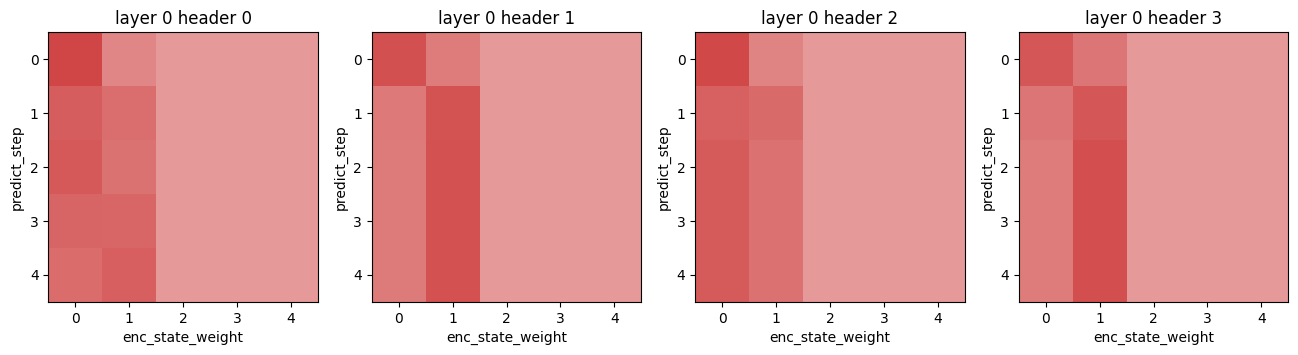

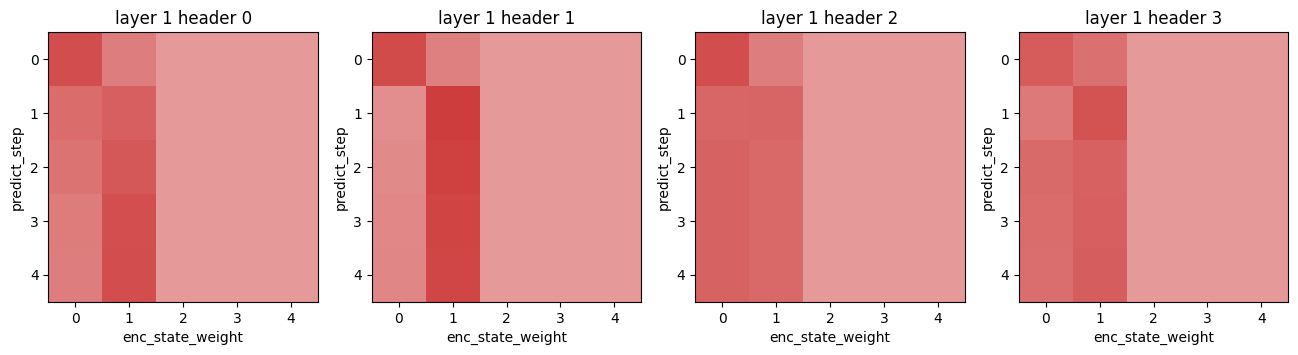

In [43]:
from attention import plot_attention_map
import matplotlib.pyplot as plt
import numpy as np

for layer in range(m.num_blocks):
    plt.figure(figsize=(16, 4))
    for h in range(m.num_head):
        plt.subplot(1, m.num_head, h + 1)
        plt.title(f"layer {layer} header {h}")
        plot_attention_map(m.encoder.attention_weights[layer][h])
        plt.ylabel("predict_step")
        plt.xlabel("enc_state_weight")
    plt.show()

# decoder注意力显示

decode step 0
 self-attention: layer 0


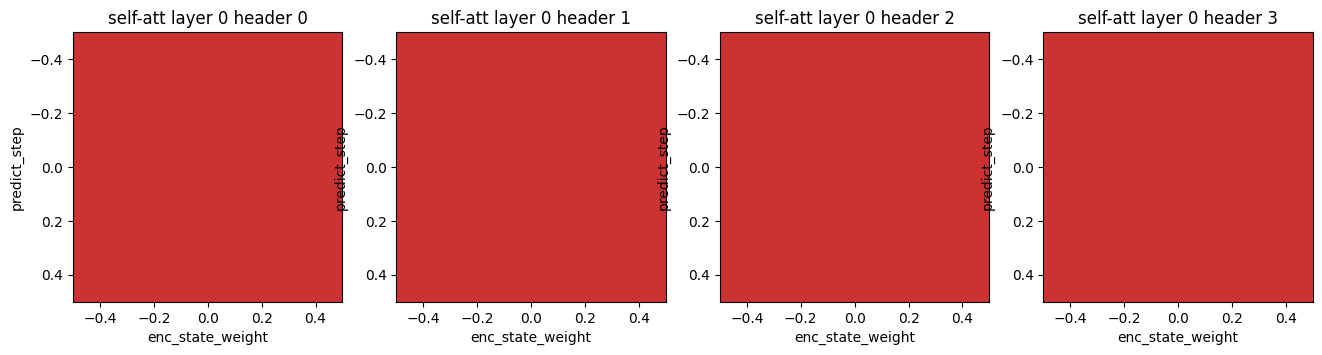

 self-attention: layer 1


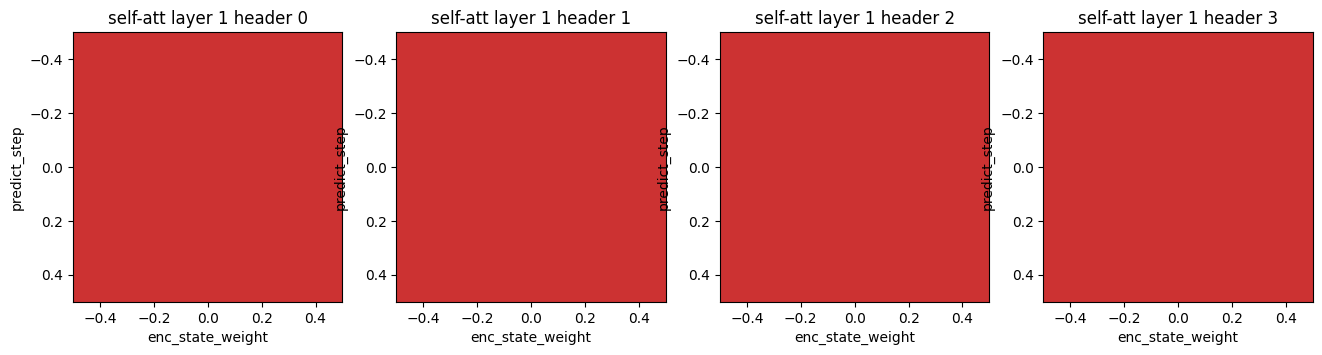

decode step 1
 self-attention: layer 0


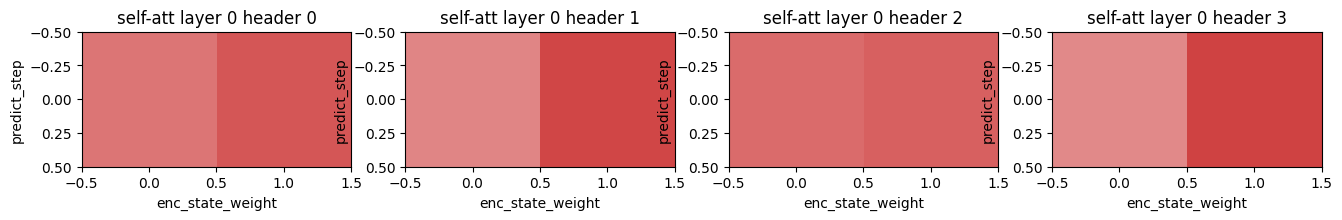

 self-attention: layer 1


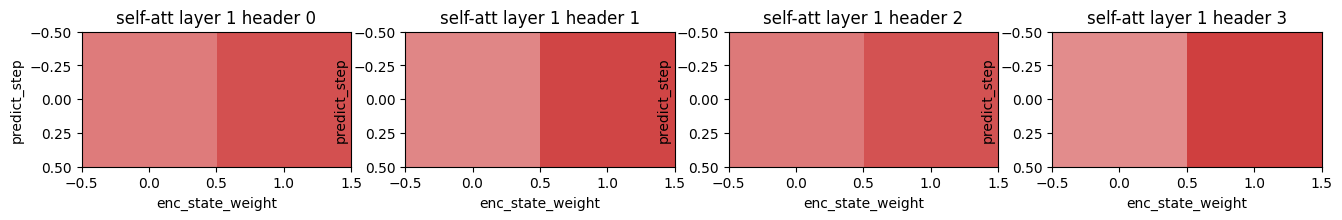

decode step 2
 self-attention: layer 0


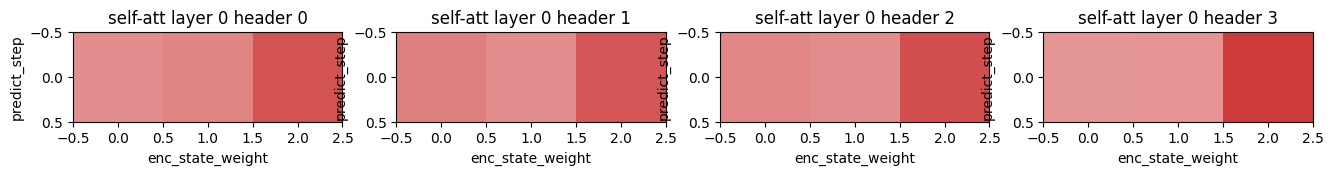

 self-attention: layer 1


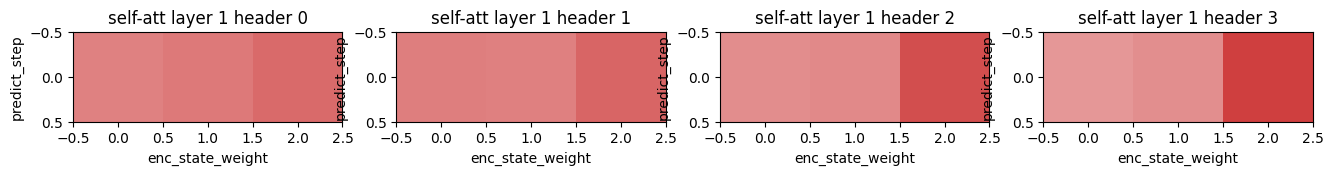

decode step 3
 self-attention: layer 0


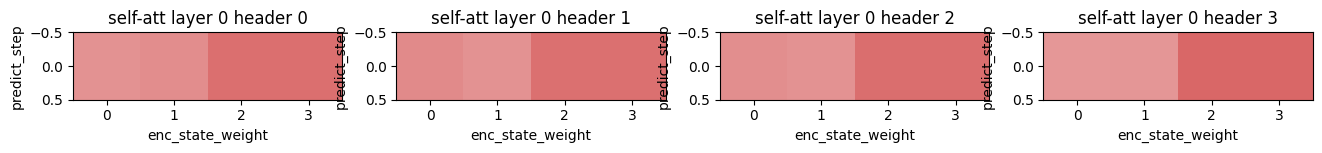

 self-attention: layer 1


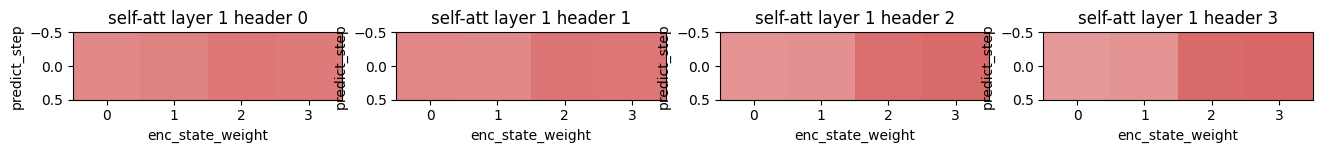

decode step 4
 self-attention: layer 0


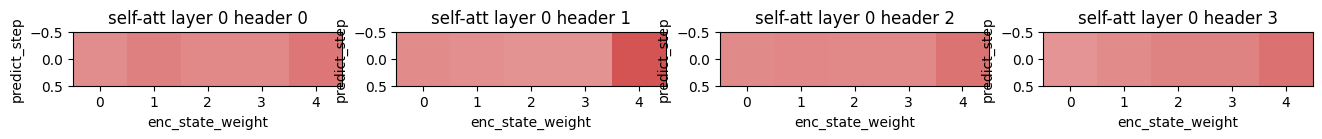

 self-attention: layer 1


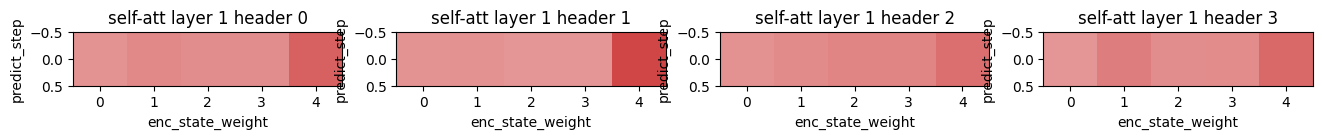

decode step 0
 enc-attention: layer 0


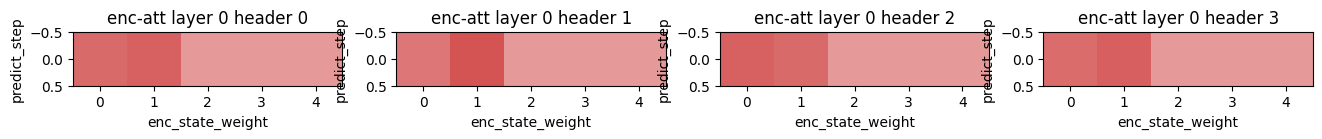

 enc-attention: layer 1


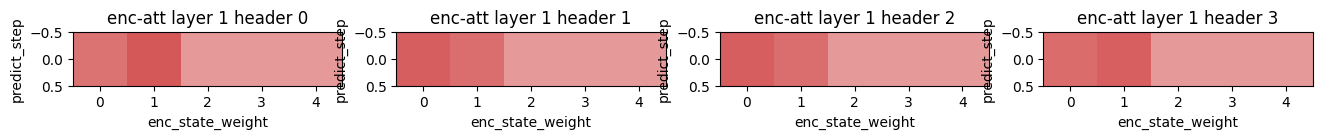

decode step 1
 enc-attention: layer 0


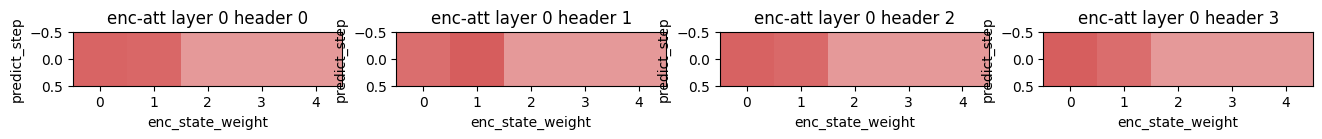

 enc-attention: layer 1


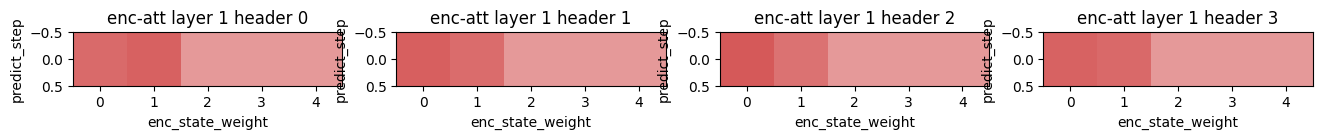

decode step 2
 enc-attention: layer 0


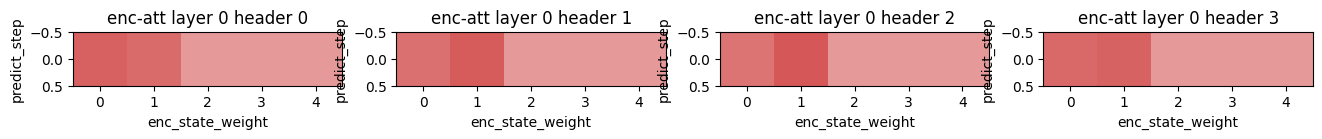

 enc-attention: layer 1


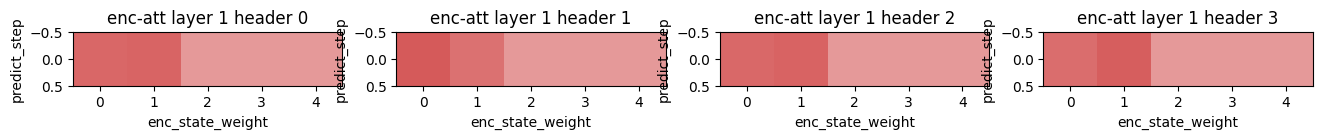

decode step 3
 enc-attention: layer 0


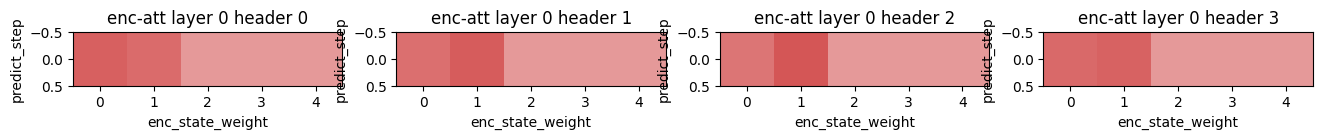

 enc-attention: layer 1


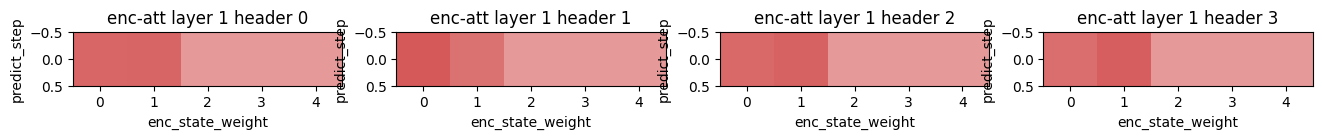

decode step 4
 enc-attention: layer 0


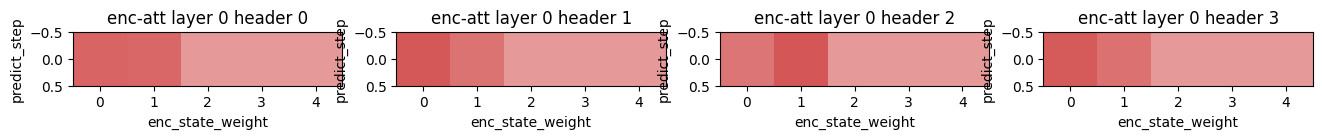

 enc-attention: layer 1


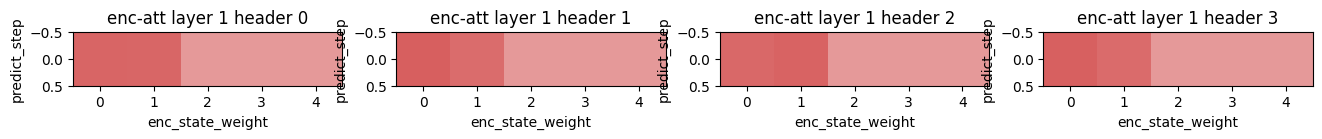

In [65]:
# self attention
for step, attention in enumerate(attentions):
    print(f"decode step {step}")
    self_att = attention[0]
    for layer in range(m.num_blocks):
        plt.figure(figsize=(16, 4))
        print(f" self-attention: layer {layer}")
        for h in range(m.num_head):
            plt.subplot(1, m.num_head, h + 1)
            plt.title(f"self-att layer {layer} header {h}")
            plot_attention_map(self_att[layer][h])
            plt.ylabel("predict_step")
            plt.xlabel("enc_state_weight")
        plt.show()
# attention with encoder output
for step, attention in enumerate(attentions):
    print(f"decode step {step}")
    enc_att = attention[1]
    for layer in range(m.num_blocks):
        plt.figure(figsize=(16, 4))
        print(f" enc-attention: layer {layer}")
        for h in range(m.num_head):
            plt.subplot(1, m.num_head, h + 1)
            plt.title(f"enc-att layer {layer} header {h}")
            plot_attention_map(enc_att[layer][h])
            plt.ylabel("predict_step")
            plt.xlabel("enc_state_weight")
        plt.show()

In [66]:
from translate_model import bleu_acc

for i in range(0, 10):
    sub_enc_x, sub_enc_valid_len, sub_dec_x, sub_target_valid_len, sub_target_y = gen[i: i + 1]
    y_pred, _ = m.translate(sub_enc_x, sub_enc_valid_len, dec_vocab=gen.y_vocab, max_len=gen.y_sentence_len)
    x = gen.x_vocab.to_tokens(list(sub_enc_x[0]))[: sub_enc_valid_len[0]]
    y_pred = y_pred.split()
    label = gen.y_vocab.to_tokens(list(sub_target_y[0]))[: sub_target_valid_len[0] - 1]
    print(x, " -> ", label)
    print(y_pred)
    print(" BLEU: ", bleu_acc(label, y_pred, 3))

['go', '.']  ->  ['va', '!']
['va', ',', ',', 'maintenant', '.']
 BLEU:  0.0
['hi', '.']  ->  ['salut', '!']
['salut', '!']
 BLEU:  1.0
['run', '!']  ->  ['cours', '!']
['sois', 'gentil', '!']
 BLEU:  0.0
['run', '!']  ->  ['courez', '!']
['sois', 'gentil', '!']
 BLEU:  0.0
['who', '?']  ->  ['qui', '?']
['qui', 'est', 'venu', '?']
 BLEU:  0.0
['wow', '!']  ->  ['ça', 'alors', '!']
['ça', 'à', 'plus', '!']
 BLEU:  0.0
['fire', '!']  ->  ['au', 'feu', '!']
['au', 'feu', '!']
 BLEU:  1.0
['help', '!']  ->  ['à', "l'aide", '!']
['salut', '!']
 BLEU:  0.42888194248035344
['jump', '.']  ->  ['saute', '.']
['saute', 'plus', "s'est", "s'est", "s'est"]
 BLEU:  0.0
['stop', '!']  ->  ['ça', 'suffit', '!']
['ça', 'fonctionne', 'plus', '!']
 BLEU:  0.0
